# AEC Compliance Agent - Tutorial 2: Calculations & Analysis

## Building Performance Analysis

This notebook demonstrates how to perform geometric calculations and circulation analysis on building data. We'll calculate room properties, find evacuation routes, and analyze building connectivity.

### What You'll Learn:

- **Geometric Calculations**: Room areas, perimeters, and spatial relationships
- **Graph Analysis**: Building connectivity and circulation patterns
- **Evacuation Routes**: Finding optimal paths to exits
- **Compliance Checking**: Verifying fire safety requirements

Let's start by importing the necessary modules and loading our example data!

In [73]:
# Import necessary libraries (self-contained per tutorial guide)
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from shapely.geometry import Polygon, Point
import networkx as nx

# Set up matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print("📊 Ready for geometric and circulation analysis")

✅ Libraries imported successfully!
📊 Ready for geometric and circulation analysis


## Loading Example Building Data

Let's load the comprehensive building data we'll use for our calculations.

In [74]:
# Load example project data
# The JSON structure has: metadata, levels[0].rooms, levels[0].doors
try:
    with open('../data/extracted/tutorial_example.json', 'r', encoding='utf-8') as f:
        project_data = json.load(f)
    
    level = project_data['levels'][0]
    print("🏗️ Project Data Loaded:")
    print(f"   Project: {project_data['metadata']['project_name']}")
    print(f"   Level: {level['name']}")
    print(f"   Rooms: {len(level['rooms'])}")
    print(f"   Doors: {len(level['doors'])}")
except FileNotFoundError:
    raise FileNotFoundError("tutorial_example.json not found. Run scripts/create_example_data.py first.")

# Normalize data into simple dicts used in this notebook
rooms = []
for r in level['rooms']:
    rooms.append({
        'id': r['id'],
        'name': r['name'],
        'level': r['level'],
        'use': r['use'],
        'area': r['area'],
        'boundary': [(p['x'], p['y']) for p in r['boundary']['points']]
    })

doors = []
for d in level['doors']:
    doors.append({
        'id': d['id'],
        'name': d.get('name', d['id']),
        'width_mm': d['width_mm'],
        'height_mm': d['height_mm'],
        'door_type': d['door_type'],
        'fire_rating': d.get('fire_rating'),
        'position': (d['position']['x'], d['position']['y']),
        'from_room': d.get('from_room'),
        'to_room': d.get('to_room'),
        'is_emergency_exit': d.get('is_emergency_exit', False)
    })

print(f"\n📋 Converted to calculation objects:")
print(f"   Rooms: {len(rooms)}")
print(f"   Doors: {len(doors)}")
print(f"   Egress doors: {sum(1 for d in doors if d['is_emergency_exit'])}")

🏗️ Project Data Loaded:
   Project: Tutorial Building Example
   Level: Planta Baja
   Rooms: 4
   Doors: 4

📋 Converted to calculation objects:
   Rooms: 4
   Doors: 4
   Egress doors: 1


## Room Geometric Calculations

Let's calculate basic geometric properties for all rooms in the building.

In [75]:
# Calculate geometric properties for all rooms
room_calculations = []

print("📐 Room Geometric Analysis:")
print("=" * 80)
print(f"{'Room ID':<8} {'Name':<20} {'Area (m²)':<10} {'Perimeter (m)':<14} {'Use Type':<15}")
print("=" * 80)

total_area = 0
total_perimeter = 0

def poly_from_boundary(boundary: List[Tuple[float, float]]) -> Polygon:
    return Polygon(boundary)

def calc_area(boundary: List[Tuple[float, float]]) -> float:
    return abs(poly_from_boundary(boundary).area)

def calc_perimeter(boundary: List[Tuple[float, float]]) -> float:
    return poly_from_boundary(boundary).length

def calc_centroid(boundary: List[Tuple[float, float]]) -> Tuple[float, float]:
    c = poly_from_boundary(boundary).centroid
    return (c.x, c.y)

def calc_bbox(boundary: List[Tuple[float, float]]) -> Tuple[float, float, float, float]:
    minx, miny, maxx, maxy = poly_from_boundary(boundary).bounds
    return (minx, miny, maxx, maxy)

for room in rooms:
    try:
        boundary = room['boundary']
        calculated_area = calc_area(boundary)
        perimeter = calc_perimeter(boundary)
        centroid = calc_centroid(boundary)
        bbox = calc_bbox(boundary)
        
        room_calc = {
            'room': room,
            'area': calculated_area,
            'perimeter': perimeter,
            'centroid': centroid,
            'bbox': bbox,
            'width': bbox[2] - bbox[0],
            'height': bbox[3] - bbox[1]
        }
        room_calculations.append(room_calc)
        
        print(f"{room['id']:<8} {room['name'][:18]:<20} {calculated_area:<10.1f} {perimeter:<14.1f} {room['use']:<15}")
        
        total_area += calculated_area
        total_perimeter += perimeter
        
    except Exception as e:
        print(f"{room['id']:<8} {room['name'][:18]:<20} {'ERROR':<10} {'ERROR':<14} {room.get('use',''):<15}")
        print(f"         Error: {str(e)}")

print("=" * 80)
print(f"{'TOTALS':<8} {'':<20} {total_area:<10.1f} {total_perimeter:<14.1f}")
print(f"\n📊 Building Summary:")
print(f"   Total Floor Area: {total_area:.1f} m²")
print(f"   Average Room Area: {total_area/len(room_calculations):.1f} m²")
print(f"   Largest Room: {max(room_calculations, key=lambda x: x['area'])['room']['name']} ({max(room_calculations, key=lambda x: x['area'])['area']:.1f} m²)")
print(f"   Smallest Room: {min(room_calculations, key=lambda x: x['area'])['room']['name']} ({min(room_calculations, key=lambda x: x['area'])['area']:.1f} m²)")

📐 Room Geometric Analysis:
Room ID  Name                 Area (m²)  Perimeter (m)  Use Type       
R001     Recepción            20.0       18.0           reception      
R002     Oficina Principal    28.0       22.0           office         
R003     Sala de Reuniones    32.0       24.0           meeting        
R004     Almacén              16.0       16.0           storage        
TOTALS                        96.0       80.0          

📊 Building Summary:
   Total Floor Area: 96.0 m²
   Average Room Area: 24.0 m²
   Largest Room: Sala de Reuniones (32.0 m²)
   Smallest Room: Almacén (16.0 m²)


## Room Area Visualization

Let's create a visual comparison of room areas and their spatial arrangement.

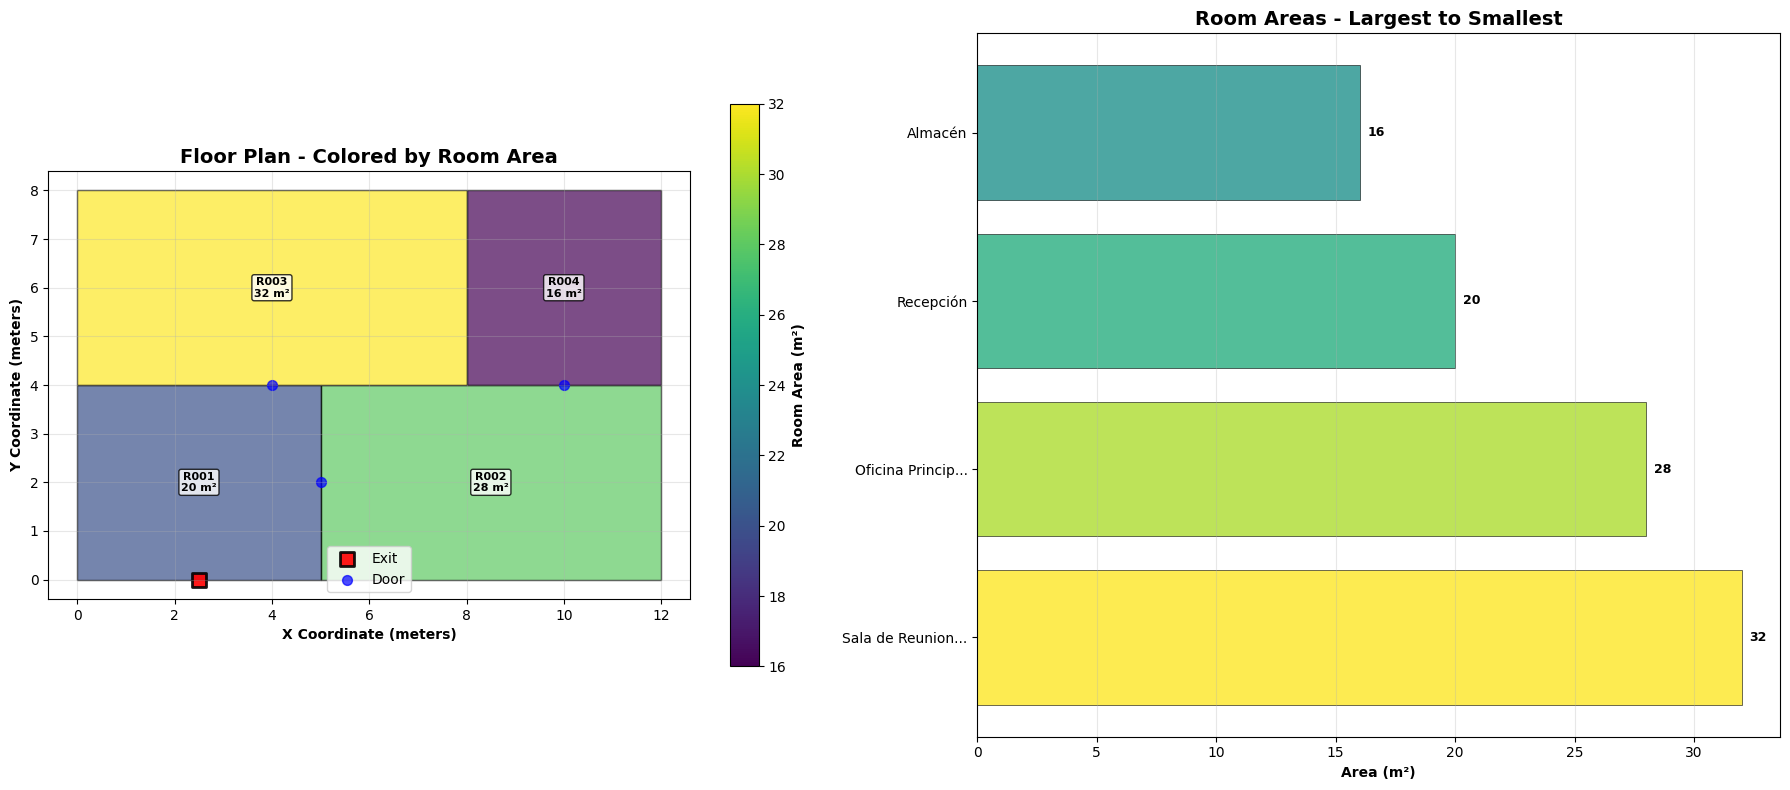

🎨 Room area analysis complete!
📊 Left: Floor plan colored by room area
📊 Right: Room areas ranked from largest to smallest


In [76]:
# Create room area visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Floor plan with area-based coloring
areas = [calc['area'] for calc in room_calculations]
min_area, max_area = min(areas), max(areas)

# Normalize areas for color mapping
norm_areas = [(area - min_area) / (max_area - min_area) if max_area > min_area else 0 for area in areas]
colors = plt.cm.viridis(norm_areas)

for i, calc in enumerate(room_calculations):
    room = calc['room']
    boundary = room['boundary']
    
    # Create polygon
    polygon = patches.Polygon(boundary, closed=True, 
                            facecolor=colors[i], alpha=0.7,
                            edgecolor='black', linewidth=1)
    ax1.add_patch(polygon)
    
    # Add room label with area
    centroid = calc['centroid']
    ax1.text(centroid[0], centroid[1], 
            f"{room['id']}\n{calc['area']:.0f} m²",
            ha='center', va='center', fontsize=8, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Add doors
egress_doors = [door for door in doors if door.get('is_emergency_exit')]
regular_doors = [door for door in doors if not door.get('is_emergency_exit')]

for idx, door in enumerate(egress_doors):
    ax1.scatter(door['position'][0], door['position'][1], 
               c='red', marker='s', s=100, alpha=0.9, 
               edgecolors='black', linewidth=2, label='Exit' if idx == 0 else "")

for idx, door in enumerate(regular_doors):
    ax1.scatter(door['position'][0], door['position'][1], 
               c='blue', marker='o', s=50, alpha=0.7,
               label='Door' if idx == 0 else "")

ax1.set_xlabel('X Coordinate (meters)', fontweight='bold')
ax1.set_ylabel('Y Coordinate (meters)', fontweight='bold')
ax1.set_title('Floor Plan - Colored by Room Area', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Add colorbar for area scale
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min_area, vmax=max_area))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, shrink=0.8)
cbar.set_label('Room Area (m²)', fontweight='bold')

# Right plot: Area distribution
room_names = [calc['room']['name'] for calc in room_calculations]
areas = [calc['area'] for calc in room_calculations]

# Sort by area for better visualization
sorted_data = sorted(zip(room_names, areas), key=lambda x: x[1], reverse=True)
sorted_names, sorted_areas = zip(*sorted_data)

bars = ax2.barh(range(len(sorted_names)), sorted_areas, 
                color=plt.cm.viridis([area/max_area if max_area > 0 else 0 for area in sorted_areas]),
                alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_yticks(range(len(sorted_names)))
ax2.set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in sorted_names])
ax2.set_xlabel('Area (m²)', fontweight='bold')
ax2.set_title('Room Areas - Largest to Smallest', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, area) in enumerate(zip(bars, sorted_areas)):
    ax2.text(area + (max_area*0.01 if max_area > 0 else 0.1), i, f'{area:.0f}', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("🎨 Room area analysis complete!")
print("📊 Left: Floor plan colored by room area")
print("📊 Right: Room areas ranked from largest to smallest")

## Building Connectivity Analysis

Now let's create a circulation graph to analyze how rooms are connected and find optimal paths.

In [77]:
# Create project object for graph analysis
# Create circulation graph with NetworkX
print("🔗 Building Circulation Graph:")
print("Creating graph representation...")

G = nx.Graph()

# Add rooms as nodes with positions (room centroids)
room_centroids: Dict[str, Tuple[float, float]] = {}
for rc in room_calculations:
    rid = rc['room']['id']
    room_centroids[rid] = (rc['centroid'][0], rc['centroid'][1])
    G.add_node(rid, name=rc['room']['name'], use=rc['room']['use'], pos=room_centroids[rid])

# Add edges for doors (between from_room and to_room)
exit_nodes = set()
for d in doors:
    frm = d.get('from_room')
    to = d.get('to_room')
    if frm == 'EXTERIOR' or to == 'EXTERIOR':
        # Track exit-connected rooms
        exit_nodes.add(frm if frm != 'EXTERIOR' else to)
        continue
    if frm and to:
        # weight as Euclidean distance between centroids
        if frm in room_centroids and to in room_centroids:
            p1, p2 = room_centroids[frm], room_centroids[to]
            w = float(np.hypot(p2[0] - p1[0], p2[1] - p1[1]))
        else:
            w = 1.0
        G.add_edge(frm, to, door_id=d['id'], weight=w, is_exit=d['is_emergency_exit'])

# Basic stats
print("\n📊 Graph Statistics:")
print("=" * 40)
print(f"   Nodes (rooms): {G.number_of_nodes()}")
print(f"   Edges (doors): {G.number_of_edges()}")

is_connected = nx.is_connected(G) if G.number_of_nodes() > 0 else False
print(f"   Connected: {is_connected}")

# Connected components
components = list(nx.connected_components(G))
print(f"\n🔗 Connectivity Analysis:")
print(f"   Connected Components: {len(components)}")
if len(components) > 1:
    print("   ⚠️ Building has disconnected areas:")
    for i, component in enumerate(components):
        print(f"      Component {i+1}: {sorted(list(component))}")
else:
    print("   ✅ All rooms are connected")

# Articulation points
articulation_points = list(nx.articulation_points(G)) if G.number_of_nodes() > 0 else []
if articulation_points:
    print(f"\n🎯 Critical Rooms (Articulation Points):")
    for room_id in articulation_points:
        room_name = next((r['name'] for r in rooms if r['id'] == room_id), room_id)
        print(f"   {room_id}: {room_name}")
    print("   ⚠️ These rooms are critical for building connectivity")
else:
    print("\n✅ No single points of failure in circulation")

# Store for later cells
circulation_graph = G
circulation_exit_rooms = {r for r in exit_nodes if r in G.nodes}

🔗 Building Circulation Graph:
Creating graph representation...

📊 Graph Statistics:
   Nodes (rooms): 4
   Edges (doors): 3
   Connected: True

🔗 Connectivity Analysis:
   Connected Components: 1
   ✅ All rooms are connected

🎯 Critical Rooms (Articulation Points):
   R002: Oficina Principal
   R001: Recepción
   ⚠️ These rooms are critical for building connectivity


## Evacuation Route Analysis

Let's find the shortest evacuation routes from each room to the nearest exit.

In [78]:
if circulation_graph and circulation_graph.number_of_nodes() > 0:
    # Calculate all evacuation routes using shortest paths to nearest exit-adjacent room
    print("🚨 Evacuation Route Analysis:")
    print("=" * 70)

    evacuation_routes: Dict[str, Dict[str, any]] = {}

    # Precompute which rooms touch exterior via a door
    exit_rooms = list(circulation_exit_rooms)

    for node in circulation_graph.nodes:
        best = {
            'distance': float('inf'),
            'path': [],
            'doors_used': []
        }
        for ex_room in exit_rooms:
            try:
                path = nx.shortest_path(circulation_graph, node, ex_room, weight='weight')
                dist = nx.path_weight(circulation_graph, path, weight='weight')
                if dist < best['distance']:
                    best['distance'] = dist
                    best['path'] = path
                    # collect door ids along path
                    doors_used = []
                    for u, v in zip(path[:-1], path[1:]):
                        data = circulation_graph.get_edge_data(u, v)
                        if data and 'door_id' in data:
                            doors_used.append(data['door_id'])
                    best['doors_used'] = doors_used
            except nx.NetworkXNoPath:
                continue
        evacuation_routes[node] = best

    # Sort by distance for analysis
    sorted_routes = sorted(evacuation_routes.items(), key=lambda x: x[1]['distance'])

    print(f"{'Room ID':<8} {'Room Name':<20} {'Distance (m)':<12} {'Path Length':<12} {'Doors Used':<10}")
    print("=" * 70)

    total_distance = 0
    successful_routes = 0

    for room_id, route in sorted_routes:
        room = next((r for r in rooms if r['id'] == room_id), None)
        room_name = room['name'] if room else room_id

        if route['distance'] < float('inf'):
            print(f"{room_id:<8} {room_name[:18]:<20} {route['distance']:<12.1f} {len(route['path']):<12} {len(route['doors_used']):<10}")
            total_distance += route['distance']
            successful_routes += 1
        else:
            print(f"{room_id:<8} {room_name[:18]:<20} {'NO PATH':<12} {'N/A':<12} {'N/A':<10}")

    if successful_routes > 0:
        avg_distance = total_distance / successful_routes
        print("=" * 70)
        print(f"\n📊 Evacuation Statistics:")
        print(f"   Successful Routes: {successful_routes}/{len(evacuation_routes)}")
        print(f"   Average Evacuation Distance: {avg_distance:.1f} m")
        valid = [r['distance'] for r in evacuation_routes.values() if r['distance'] < float('inf')]
        print(f"   Longest Evacuation Distance: {max(valid):.1f} m")
        print(f"   Shortest Evacuation Distance: {min(valid):.1f} m")

        max_distance = max(valid)
        if max_distance <= 25:
            print("   ✅ All evacuation distances within protected route limit (25m)")
        elif max_distance <= 35:
            print("   ⚠️ Some routes exceed protected limit but within unprotected limit (35m)")
        else:
            print("   ❌ Some evacuation routes exceed regulatory limits")

    # Find the longest evacuation route for visualization
    def key_fn(item):
        d = item[1]['distance']
        return d if d < float('inf') else -1

    longest_route_room = max(evacuation_routes.items(), key=key_fn)

    print(f"\n🔍 Longest Evacuation Route:")
    lr_room = next((r for r in rooms if r['id'] == longest_route_room[0]), None)
    print(f"   From: {longest_route_room[0]} ({lr_room['name'] if lr_room else 'Unknown'})")
    print(f"   Distance: {longest_route_room[1]['distance']:.1f} m")
    print(f"   Path: {' → '.join(longest_route_room[1]['path'])}")
    print(f"   Doors: {', '.join(longest_route_room[1]['doors_used'])}")

else:
    print("❌ Cannot analyze evacuation routes without circulation graph")

🚨 Evacuation Route Analysis:
Room ID  Room Name            Distance (m) Path Length  Doors Used
R001     Recepción            0.0          1            0         
R003     Sala de Reuniones    4.3          2            1         
R002     Oficina Principal    6.0          2            1         
R004     Almacén              10.3         3            2         

📊 Evacuation Statistics:
   Successful Routes: 4/4
   Average Evacuation Distance: 5.1 m
   Longest Evacuation Distance: 10.3 m
   Shortest Evacuation Distance: 0.0 m
   ✅ All evacuation distances within protected route limit (25m)

🔍 Longest Evacuation Route:
   From: R004 (Almacén)
   Distance: 10.3 m
   Path: R004 → R002 → R001
   Doors: D004, D002


## Circulation Graph Visualization

Let's visualize the building's circulation network and highlight evacuation routes.

🎨 Overlaying circulation graph on floor plan...


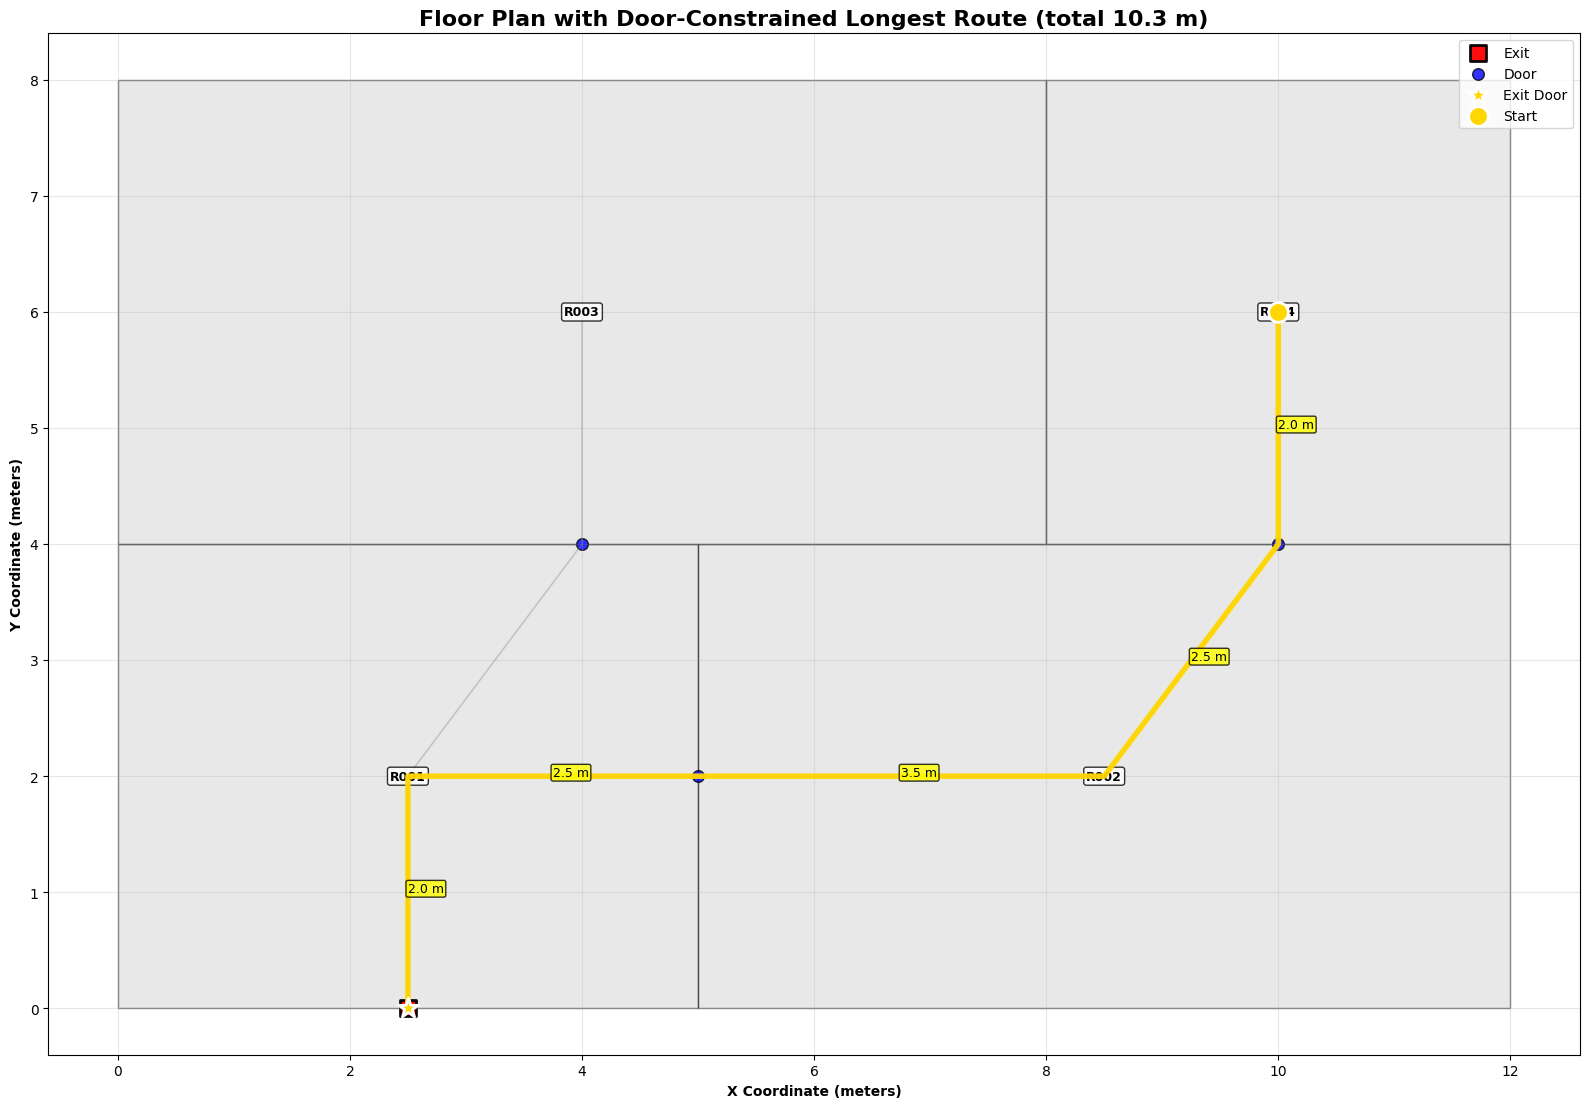

✅ Overlay visualization complete!
📊 The drawing shows rooms, doors, distances on connections, and the longest route highlighted.


In [79]:
if circulation_graph and circulation_graph.number_of_nodes() > 0:
    print("🎨 Overlaying circulation graph on floor plan...")

    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Draw rooms as polygons
    for calc in room_calculations:
        room = calc['room']
        boundary = room['boundary']
        polygon = patches.Polygon(boundary, closed=True, facecolor='lightgray', alpha=0.5,
                                  edgecolor='black', linewidth=1)
        ax.add_patch(polygon)
        cx, cy = calc['centroid']
        ax.text(cx, cy, f"{room['id']}", ha='center', va='center', fontsize=9,
                fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

    # Draw doors
    egress_doors = [door for door in doors if door.get('is_emergency_exit')]
    regular_doors = [door for door in doors if not door.get('is_emergency_exit')]

    for idx, door in enumerate(egress_doors):
        ax.scatter(door['position'][0], door['position'][1], c='red', marker='s', s=120,
                   alpha=0.95, edgecolors='black', linewidth=2, label='Exit' if idx == 0 else "")
    for idx, door in enumerate(regular_doors):
        ax.scatter(door['position'][0], door['position'][1], c='blue', marker='o', s=70,
                   alpha=0.8, edgecolors='black', linewidth=1, label='Door' if idx == 0 else "")

    # Positions of nodes (room centroids)
    pos = {rc['room']['id']: (rc['centroid'][0], rc['centroid'][1]) for rc in room_calculations}

    # Draw all room-to-exit routes as light door-constrained polylines (no lines through walls)
    if 'evacuation_routes' in globals() and evacuation_routes:
        door_id_to_pos = {d['id']: d['position'] for d in doors}
        for room_id, route in evacuation_routes.items():
            path = route.get('path', [])
            if not path or route.get('distance', float('inf')) == float('inf'):
                continue
            # Build polyline via doors
            poly_x, poly_y = [], []
            def addp(px, py):
                poly_x.append(px); poly_y.append(py)
            sx, sy = pos[path[0]]
            addp(sx, sy)
            for u, v in zip(path[:-1], path[1:]):
                data = circulation_graph.get_edge_data(u, v) or {}
                door_id = data.get('door_id')
                if door_id and door_id in door_id_to_pos:
                    dx, dy = door_id_to_pos[door_id]
                    addp(dx, dy)
                cx, cy = pos[v]
                addp(cx, cy)
            # extend to exit door position if last room touches exit
            last_room = path[-1]
            exit_doors_for_room = [d for d in doors if d.get('is_emergency_exit') and (d.get('from_room') == last_room or d.get('to_room') == last_room)]
            if exit_doors_for_room:
                ex_door = exit_doors_for_room[0]
                exx, exy = ex_door['position']
                addp(exx, exy)
            ax.plot(poly_x, poly_y, color='gray', linewidth=1.2, alpha=0.35, zorder=2)

    # Optionally select a specific room to show its route; otherwise show longest
    selected_room_id = None  # e.g., 'R003' to force R003's route

    route_to_show = None
    if 'evacuation_routes' in globals() and evacuation_routes:
        if selected_room_id and selected_room_id in evacuation_routes:
            route_to_show = ('selected', selected_room_id, evacuation_routes[selected_room_id])
        elif 'longest_route_room' in locals():
            route_to_show = ('longest', longest_route_room[0], longest_route_room[1])

    # Highlight door-constrained evacuation path if available
    if route_to_show:
        route_kind, route_room_id, route_info = route_to_show
        path = route_info['path']

        # Build a polyline that passes through door positions instead of straight through walls
        polyline_x = []
        polyline_y = []

        def append_point(px, py):
            polyline_x.append(px)
            polyline_y.append(py)

        if path:
            # start at first room centroid
            sx, sy = pos[path[0]]
            append_point(sx, sy)

        # Map door_id -> position for fast lookup
        door_id_to_pos = {d['id']: d['position'] for d in doors}

        # Walk edges in path and insert door waypoints
        for u, v in zip(path[:-1], path[1:]):
            data = circulation_graph.get_edge_data(u, v) or {}
            door_id = data.get('door_id')
            # If we have a door id, route via that door position
            if door_id and door_id in door_id_to_pos:
                dx, dy = door_id_to_pos[door_id]
                append_point(dx, dy)
            # then add next room centroid
            cx, cy = pos[v]
            append_point(cx, cy)

        # If the last room is exit-adjacent, extend to the exit door position
        if path:
            last_room = path[-1]
            exit_doors_for_room = [d for d in doors if d.get('is_emergency_exit') and (d.get('from_room') == last_room or d.get('to_room') == last_room)]
            if exit_doors_for_room:
                ex_door = exit_doors_for_room[0]
                exx, exy = ex_door['position']
                append_point(exx, exy)
                # mark exit door
                ax.scatter(exx, exy, c='gold', s=220, marker='*', edgecolors='white', linewidth=2, zorder=6, label='Exit Door')

        # Draw the polyline in yellow
        ax.plot(polyline_x, polyline_y, color='gold', linewidth=4, alpha=0.95, zorder=5)

        # Annotate each segment with its distance
        for i in range(len(polyline_x) - 1):
            x1, y1 = polyline_x[i], polyline_y[i]
            x2, y2 = polyline_x[i+1], polyline_y[i+1]
            seg_len = float(np.hypot(x2 - x1, y2 - y1))
            mx, my = (x1 + x2) / 2.0, (y1 + y2) / 2.0
            ax.text(mx, my, f"{seg_len:.1f} m", color='black', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.15', facecolor='yellow', alpha=0.8), zorder=6)

        # annotate start room
        if path:
            sx, sy = pos[path[0]]
            ax.scatter(sx, sy, c='gold', s=200, marker='o', edgecolors='white', linewidth=2, zorder=6, label='Start')

        # Title reflects selected or longest route and total distance
        total_dist = route_info.get('distance', float('inf'))
        if route_kind == 'selected':
            ax.set_title(f"Door-Constrained Evacuation Route for {route_room_id} (total {total_dist:.1f} m)", fontsize=16, fontweight='bold')
        else:
            ax.set_title(f"Floor Plan with Door-Constrained Longest Route (total {total_dist:.1f} m)", fontsize=16, fontweight='bold')
    else:
        ax.set_title('Floor Plan with Circulation Graph', fontsize=16, fontweight='bold')

    ax.set_xlabel('X Coordinate (meters)', fontweight='bold')
    ax.set_ylabel('Y Coordinate (meters)', fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

    print("✅ Overlay visualization complete!")
    print("📊 The drawing shows rooms, doors, distances on connections, and the longest route highlighted.")
else:
    print("❌ Cannot visualize without circulation graph")

## Fire Equipment Coverage Analysis

Let's calculate which areas are covered by fire equipment based on their positions.

In [10]:
# Fire Equipment Coverage Analysis (simplified for tutorial)
print("🔥 Fire Equipment Coverage Analysis:")
print("=" * 60)

# For this tutorial, we'll simulate fire equipment coverage
# In a real system, this would come from the building data

# Simulate fire equipment positions and coverage
fire_equipment = [
    {'equipment_type': 'extinguisher', 'position': (6.0, 2.0), 'coverage_radius': 15.0},
    {'equipment_type': 'hydrant', 'position': (2.5, 6.0), 'coverage_radius': 20.0},
    {'equipment_type': 'alarm', 'position': (10.0, 2.0), 'coverage_radius': 25.0}
]

def distance_between_points(p1, p2):
    """Calculate distance between two points."""
    return np.hypot(p2[0] - p1[0], p2[1] - p1[1])

# Calculate which rooms are covered by each type of equipment
equipment_types = {}
room_coverage = {room['id']: {'extinguisher': False, 'hydrant': False, 'alarm': False} for room in rooms}

for equipment in fire_equipment:
    eq_type = equipment['equipment_type']
    eq_pos = equipment['position']
    coverage_radius = equipment.get('coverage_radius', 15.0)
    
    if eq_type not in equipment_types:
        equipment_types[eq_type] = []
    equipment_types[eq_type].append(equipment)
    
    # Check which rooms are within coverage
    for room_calc in room_calculations:
        room_centroid = room_calc['centroid']
        distance = distance_between_points(eq_pos, room_centroid)
        
        if distance <= coverage_radius:
            if eq_type in room_coverage[room_calc['room']['id']]:
                room_coverage[room_calc['room']['id']][eq_type] = True

# Summary by equipment type
for eq_type, equipment_list in equipment_types.items():
    print(f"\n{eq_type.replace('_', ' ').title()}:")
    print(f"   Count: {len(equipment_list)}")
    
    covered_rooms = sum(1 for coverage in room_coverage.values() 
                      if coverage.get(eq_type, False))
    coverage_percentage = (covered_rooms / len(rooms)) * 100
    print(f"   Room Coverage: {covered_rooms}/{len(rooms)} ({coverage_percentage:.1f}%)")
    
    # Average coverage radius
    avg_radius = sum(eq.get('coverage_radius', 15.0) for eq in equipment_list) / len(equipment_list)
    print(f"   Average Coverage Radius: {avg_radius:.1f} m")

# Room-by-room coverage analysis
print(f"\n📋 Room Coverage Details:")
print(f"{'Room ID':<8} {'Room Name':<20} {'Extinguisher':<12} {'Hydrant':<8} {'Alarm':<8} {'Score':<6}")
print("=" * 70)

for room in rooms:
    coverage = room_coverage[room['id']]
    score = sum(1 for covered in coverage.values() if covered)
    
    ext_status = "✅" if coverage.get('extinguisher', False) else "❌"
    hyd_status = "✅" if coverage.get('hydrant', False) else "❌"
    alarm_status = "✅" if coverage.get('alarm', False) else "❌"
    
    print(f"{room['id']:<8} {room['name'][:18]:<20} {ext_status:<12} {hyd_status:<8} {alarm_status:<8} {score}/3")

# Overall coverage statistics
total_covered = sum(1 for coverage in room_coverage.values() 
                   if any(coverage.values()))
fully_covered = sum(1 for coverage in room_coverage.values() 
                   if all(coverage.values()))

print("=" * 70)
print(f"\n📊 Overall Coverage Statistics:")
print(f"   Rooms with any coverage: {total_covered}/{len(rooms)} ({(total_covered/len(rooms)*100):.1f}%)")
print(f"   Rooms with full coverage: {fully_covered}/{len(rooms)} ({(fully_covered/len(rooms)*100):.1f}%)")

if total_covered == len(rooms):
    print("   ✅ All rooms have some fire protection coverage")
else:
    uncovered = len(rooms) - total_covered
    print(f"   ⚠️ {uncovered} rooms lack fire protection coverage")

🔥 Fire Equipment Coverage Analysis:

Extinguisher:
   Count: 1
   Room Coverage: 4/4 (100.0%)
   Average Coverage Radius: 15.0 m

Hydrant:
   Count: 1
   Room Coverage: 4/4 (100.0%)
   Average Coverage Radius: 20.0 m

Alarm:
   Count: 1
   Room Coverage: 4/4 (100.0%)
   Average Coverage Radius: 25.0 m

📋 Room Coverage Details:
Room ID  Room Name            Extinguisher Hydrant  Alarm    Score 
R001     Recepción            ✅            ✅        ✅        3/3
R002     Oficina Principal    ✅            ✅        ✅        3/3
R003     Sala de Reuniones    ✅            ✅        ✅        3/3
R004     Almacén              ✅            ✅        ✅        3/3

📊 Overall Coverage Statistics:
   Rooms with any coverage: 4/4 (100.0%)
   Rooms with full coverage: 4/4 (100.0%)
   ✅ All rooms have some fire protection coverage


## Interactive Room Analysis

Let's create an interactive analysis where you can explore specific rooms and their properties.

In [ ]:
# Interactive room analysis function
def analyze_room_details(room_id: str):
    """Detailed analysis of a specific room."""
    
    # Find the room
    room = next((r for r in rooms if r['id'] == room_id), None)
    if not room:
        print(f"❌ Room {room_id} not found!")
        return
    
    # Get calculation data
    room_calc = next((calc for calc in room_calculations if calc['room']['id'] == room_id), None)
    
    print(f"🏠 Detailed Analysis: {room['name']} ({room_id})")
    print("=" * 60)
    
    # Basic properties
    print(f"Use Type: {room['use'].replace('_', ' ').title()}")
    print(f"Level: {room['level']}")
    if room_calc:
        print(f"Area: {room_calc['area']:.1f} m²")
        print(f"Perimeter: {room_calc['perimeter']:.1f} m")
        print(f"Dimensions: {room_calc['width']:.1f} × {room_calc['height']:.1f} m")
        print(f"Centroid: ({room_calc['centroid'][0]:.1f}, {room_calc['centroid'][1]:.1f})")
    
    # Adjacent rooms (simplified - rooms that share a door)
    print(f"\n🔗 Adjacent Rooms:")
    adjacent_rooms = []
    for door in doors:
        if door['from_room'] == room_id and door['to_room'] != 'EXTERIOR':
            adj_room = next((r for r in rooms if r['id'] == door['to_room']), None)
            if adj_room and adj_room not in adjacent_rooms:
                adjacent_rooms.append(adj_room)
        elif door['to_room'] == room_id and door['from_room'] != 'EXTERIOR':
            adj_room = next((r for r in rooms if r['id'] == door['from_room']), None)
            if adj_room and adj_room not in adjacent_rooms:
                adjacent_rooms.append(adj_room)
    
    if adjacent_rooms:
        for adj_room in adjacent_rooms:
            print(f"   - {adj_room['id']}: {adj_room['name']}")
    else:
        print("   No adjacent rooms detected")
    
    # Evacuation analysis
    if 'evacuation_routes' in globals() and room_id in evacuation_routes:
        route = evacuation_routes[room_id]
        print(f"\n🚨 Evacuation Route:")
        if route['distance'] < float('inf'):
            print(f"   Distance to Exit: {route['distance']:.1f} m")
            print(f"   Path: {' → '.join(route['path'])}")
            print(f"   Doors Used: {', '.join(route['doors_used']) if route['doors_used'] else 'None'}")
        else:
            print("   ❌ No evacuation route available")
    
    # Nearest exit (direct distance to emergency exit doors)
    if room_calc:
        emergency_doors = [d for d in doors if d['is_emergency_exit']]
        if emergency_doors:
            nearest_door = min(emergency_doors, 
                             key=lambda d: distance_between_points(room_calc['centroid'], d['position']))
            exit_distance = distance_between_points(room_calc['centroid'], nearest_door['position'])
            print(f"\n🚪 Nearest Exit:")
            print(f"   Door: {nearest_door['id']}")
            print(f"   Direct Distance: {exit_distance:.1f} m")
    
    # Fire equipment coverage
    if 'room_coverage' in globals() and room_id in room_coverage:
        coverage = room_coverage[room_id]
        print(f"\n🔥 Fire Protection Coverage:")
        for eq_type, is_covered in coverage.items():
            status = "✅" if is_covered else "❌"
            print(f"   {eq_type.replace('_', ' ').title()}: {status}")

# Demonstrate with a few example rooms
print("🔍 Interactive Room Analysis Examples:")
print("\n" + "="*80)

# Analyze the largest room
largest_room = max(room_calculations, key=lambda x: x['area'])['room']
analyze_room_details(largest_room['id'])

print("\n" + "="*80)

# Analyze a reception room (important for circulation)
reception_room = next((r for r in rooms if r['use'] == 'reception'), None)
if reception_room:
    analyze_room_details(reception_room['id'])

print("\n💡 Try analyzing other rooms by calling: analyze_room_details('ROOM_ID')")
print(f"Available rooms: {', '.join([r['id'] for r in rooms[:10]])}{'...' if len(rooms) > 10 else ''}")

🔍 Interactive Room Analysis Examples:

🏠 Detailed Analysis: Sala de Reuniones (R003)
Use Type: Meeting
Level: Planta Baja
Area: 32.0 m²
Perimeter: 24.0 m
Dimensions: 8.0 × 4.0 m
Centroid: (4.0, 6.0)

🔗 Adjacent Rooms:
   - R001: Recepción

🚪 Nearest Exit:
   Door: D001
   Direct Distance: 6.2 m

🏠 Detailed Analysis: Recepción (R001)
Use Type: Reception
Level: Planta Baja
Area: 20.0 m²
Perimeter: 18.0 m
Dimensions: 5.0 × 4.0 m
Centroid: (2.5, 2.0)

🔗 Adjacent Rooms:
   - R002: Oficina Principal
   - R003: Sala de Reuniones

🚪 Nearest Exit:
   Door: D001
   Direct Distance: 2.0 m

💡 Try analyzing other rooms by calling: analyze_room_details('ROOM_ID')
Available rooms: R001, R002, R003, R004


## Summary & Compliance Assessment

Let's create a comprehensive compliance report based on our calculations.

In [12]:
# Generate comprehensive compliance report
print("📋 AEC COMPLIANCE ASSESSMENT REPORT")
print("=" * 80)
print(f"Project: {project_data['metadata']['project_name']}")
print(f"Analysis Date: {project_data['metadata']['created_date'][:10]}")
print(f"Building Use: {project_data['metadata']['building_type'].title()}")
print("=" * 80)

# Building metrics
print(f"\n🏢 BUILDING METRICS:")
print(f"   Total Floor Area: {total_area:.1f} m²")
print(f"   Number of Rooms: {len(rooms)}")
print(f"   Number of Doors: {len(doors)}")
print(f"   Number of Exits: {len([d for d in doors if d['is_emergency_exit']])}")

# Circulation assessment
print(f"\n🔗 CIRCULATION ASSESSMENT:")
if circulation_graph and circulation_graph.number_of_nodes() > 0:
    is_connected = nx.is_connected(circulation_graph)
    print(f"   Building Connectivity: {'✅ Connected' if is_connected else '❌ Disconnected'}")
    if is_connected:
        avg_path_length = nx.average_shortest_path_length(circulation_graph)
        print(f"   Average Path Length: {avg_path_length:.1f}")
    else:
        print(f"   Connected Components: {len(list(nx.connected_components(circulation_graph)))}")
else:
    print("   ❌ Unable to assess circulation")

# Evacuation assessment
print(f"\n🚨 EVACUATION ASSESSMENT:")
if 'evacuation_routes' in locals() and evacuation_routes:
    successful_routes = sum(1 for route in evacuation_routes.values() if route['distance'] < float('inf'))
    if successful_routes == len(rooms):
        print("   Route Availability: ✅ All rooms have evacuation routes")
    else:
        print(f"   Route Availability: ⚠️ {len(rooms) - successful_routes} rooms lack evacuation routes")
    
    valid_distances = [r['distance'] for r in evacuation_routes.values() if r['distance'] < float('inf')]
    if valid_distances:
        max_distance = max(valid_distances)
        avg_distance = sum(valid_distances) / len(valid_distances)
        print(f"   Maximum Evacuation Distance: {max_distance:.1f} m")
        print(f"   Average Evacuation Distance: {avg_distance:.1f} m")
        
        # Compliance check (Spanish CTE DB SI typical limits)
        if max_distance <= 25:
            print("   Distance Compliance: ✅ Within protected route limits")
        elif max_distance <= 35:
            print("   Distance Compliance: ⚠️ Exceeds protected limits but within general limits")
        else:
            print("   Distance Compliance: ❌ Exceeds regulatory limits")
else:
    print("   ❌ Unable to assess evacuation routes")

# Fire protection assessment
print(f"\n🔥 FIRE PROTECTION ASSESSMENT:")
if 'fire_equipment' in locals() and 'room_coverage' in locals():
    total_coverage = sum(1 for coverage in room_coverage.values() if any(coverage.values()))
    full_coverage = sum(1 for coverage in room_coverage.values() if all(coverage.values()))
    
    print(f"   Equipment Count: {len(fire_equipment)} units")
    print(f"   Room Coverage: {total_coverage}/{len(rooms)} ({(total_coverage/len(rooms)*100):.1f}%)")
    print(f"   Full Protection: {full_coverage}/{len(rooms)} ({(full_coverage/len(rooms)*100):.1f}%)")
    
    if total_coverage == len(rooms):
        print("   Coverage Compliance: ✅ All rooms have fire protection")
    else:
        print(f"   Coverage Compliance: ⚠️ {len(rooms) - total_coverage} rooms lack protection")
else:
    print("   ❌ Unable to assess fire protection")

# Room size compliance
print(f"\n📐 ROOM SIZE COMPLIANCE:")
oversized_rooms = [calc for calc in room_calculations if calc['area'] > 2500]  # Example limit
undersized_rooms = [calc for calc in room_calculations if calc['area'] < 5]     # Example minimum

if oversized_rooms:
    print(f"   Oversized Rooms: ⚠️ {len(oversized_rooms)} rooms exceed 2500 m²")
    for calc in oversized_rooms[:3]:  # Show first 3
        print(f"      {calc['room']['id']}: {calc['area']:.1f} m²")
else:
    print("   Room Sizes: ✅ All rooms within reasonable limits")

# Overall compliance score
print(f"\n🎯 OVERALL COMPLIANCE SCORE:")
score_items = []

# Connectivity (25 points)
if circulation_graph and circulation_graph.number_of_nodes() > 0 and nx.is_connected(circulation_graph):
    score_items.append(25)
else:
    score_items.append(0)

# Evacuation routes (35 points)
if 'evacuation_routes' in locals() and evacuation_routes:
    successful_routes = sum(1 for route in evacuation_routes.values() if route['distance'] < float('inf'))
    evacuation_score = (successful_routes / len(rooms)) * 35
    score_items.append(evacuation_score)
else:
    score_items.append(0)

# Fire protection (25 points)
if 'room_coverage' in locals():
    total_coverage = sum(1 for coverage in room_coverage.values() if any(coverage.values()))
    protection_score = (total_coverage / len(rooms)) * 25
    score_items.append(protection_score)
else:
    score_items.append(0)

# Data completeness (15 points)
data_score = 15  # We have complete room and door data
score_items.append(data_score)

total_score = sum(score_items)

print(f"   Connectivity: {score_items[0]:.0f}/25")
print(f"   Evacuation: {score_items[1]:.0f}/35")
print(f"   Fire Protection: {score_items[2]:.0f}/25")
print(f"   Data Quality: {score_items[3]:.0f}/15")
print(f"   " + "="*30)
print(f"   TOTAL SCORE: {total_score:.0f}/100")

if total_score >= 90:
    grade = "✅ EXCELLENT"
elif total_score >= 75:
    grade = "✅ GOOD"
elif total_score >= 60:
    grade = "⚠️ ACCEPTABLE"
else:
    grade = "❌ NEEDS IMPROVEMENT"

print(f"   COMPLIANCE GRADE: {grade}")

print(f"\n" + "="*80)
print("📝 RECOMMENDATIONS:")
recommendations = []

if not circulation_graph or circulation_graph.number_of_nodes() == 0 or not nx.is_connected(circulation_graph):
    recommendations.append("• Improve building connectivity - some areas are isolated")

if 'evacuation_routes' in locals() and evacuation_routes:
    failed_routes = sum(1 for route in evacuation_routes.values() if route['distance'] >= float('inf'))
    if failed_routes > 0:
        recommendations.append(f"• Provide evacuation routes for {failed_routes} inaccessible rooms")
    
    valid_distances = [r['distance'] for r in evacuation_routes.values() if r['distance'] < float('inf')]
    if valid_distances and max(valid_distances) > 35:
        recommendations.append("• Reduce maximum evacuation distances or provide protected routes")

if 'room_coverage' in locals():
    uncovered = sum(1 for coverage in room_coverage.values() if not any(coverage.values()))
    if uncovered > 0:
        recommendations.append(f"• Install fire protection equipment in {uncovered} uncovered rooms")

if not recommendations:
    recommendations.append("• Building meets basic compliance requirements")
    recommendations.append("• Consider periodic review and updates as regulations change")

for rec in recommendations:
    print(rec)

print(f"\n" + "="*80)
print("✅ Compliance assessment complete!")

📋 AEC COMPLIANCE ASSESSMENT REPORT
Project: Tutorial Building Example
Analysis Date: 2024-01-15
Building Use: Commercial

🏢 BUILDING METRICS:
   Total Floor Area: 96.0 m²
   Number of Rooms: 4
   Number of Doors: 4
   Number of Exits: 1

🔗 CIRCULATION ASSESSMENT:
   Building Connectivity: ✅ Connected
   Average Path Length: 1.7

🚨 EVACUATION ASSESSMENT:
   Route Availability: ✅ All rooms have evacuation routes
   Maximum Evacuation Distance: 10.3 m
   Average Evacuation Distance: 5.1 m
   Distance Compliance: ✅ Within protected route limits

🔥 FIRE PROTECTION ASSESSMENT:
   Equipment Count: 3 units
   Room Coverage: 4/4 (100.0%)
   Full Protection: 4/4 (100.0%)
   Coverage Compliance: ✅ All rooms have fire protection

📐 ROOM SIZE COMPLIANCE:
   Room Sizes: ✅ All rooms within reasonable limits

🎯 OVERALL COMPLIANCE SCORE:
   Connectivity: 25/25
   Evacuation: 35/35
   Fire Protection: 25/25
   Data Quality: 15/15
   TOTAL SCORE: 100/100
   COMPLIANCE GRADE: ✅ EXCELLENT

📝 RECOMMENDATION

## Summary

In this tutorial, we've learned how to:

### 🔧 **Geometric Calculations**
- Calculate room areas and perimeters using the Shapely library
- Find room centroids and bounding boxes
- Analyze spatial relationships between rooms

### 🕸️ **Graph-Based Analysis**
- Create circulation graphs from building data
- Analyze building connectivity and identify critical paths
- Find articulation points that are crucial for circulation

### 🚨 **Evacuation Planning**
- Calculate shortest evacuation routes from each room
- Analyze evacuation distances for compliance
- Visualize circulation patterns and critical routes

### 🔥 **Fire Safety Analysis**
- Assess fire equipment coverage across the building
- Identify areas lacking adequate protection
- Calculate equipment effectiveness and placement

### 📊 **Compliance Assessment**
- Generate comprehensive compliance reports
- Score buildings against regulatory requirements
- Provide actionable recommendations for improvements

### Key Takeaways:

1. **Automation is Key**: These calculations would be tedious by hand but are instant with code
2. **Visual Analysis**: Graphs and floor plans reveal patterns not obvious in raw data
3. **Compliance Checking**: Systematic analysis ensures nothing is missed
4. **Optimization Opportunities**: Analysis reveals where improvements can be made

### Next Steps:

With these calculation tools, you can:
- Analyze your own building projects
- Customize compliance criteria for different regulations
- Integrate with CAD software for automated analysis
- Develop specialized tools for specific building types

**Want to explore more?** Try running `analyze_room_details()` with different room IDs to dive deeper into specific areas!